C:\Users\Seamus-admin\AppData\Local\Temp\2\ipykernel_20420\1225142174.py:5: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(



Average xG per corner (Horsens): 0.033
Total xG from corner (Horsens): 2.214
Number of corners (Horsens): 68


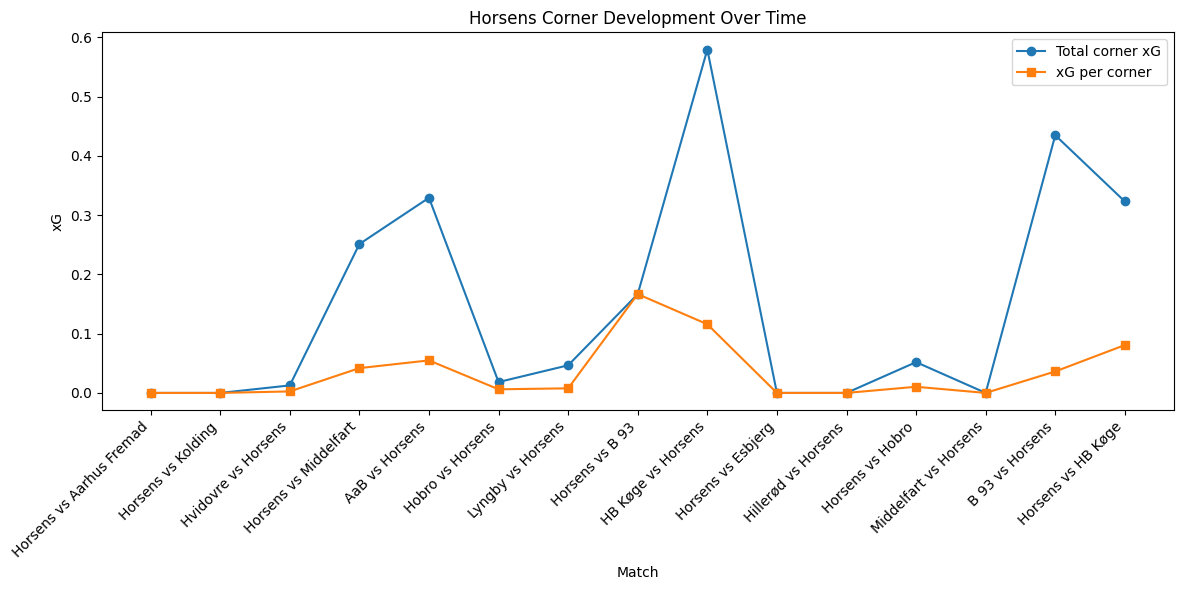


=== League table: Corner (xG per piece, total xG, count) ===
    team_name  xG_per_piece  xG_total  corner_taken
        Hobro         0.058     3.759            65
      Horsens         0.033     2.214            68
     Hvidovre         0.033     2.173            65
     Hillerød         0.031     1.958            63
      Esbjerg         0.030     2.065            69
          AaB         0.027     2.417            89
         B 93         0.024     1.505            63
      HB Køge         0.023     1.041            45
Aarhus Fremad         0.021     1.610            76
   Middelfart         0.019     1.073            57
      Kolding         0.015     1.349            88
       Lyngby         0.014     0.984            68

Average xG per freekick (Horsens): 0.034
Total xG from freekick (Horsens): 0.973
Number of freekicks (Horsens): 29


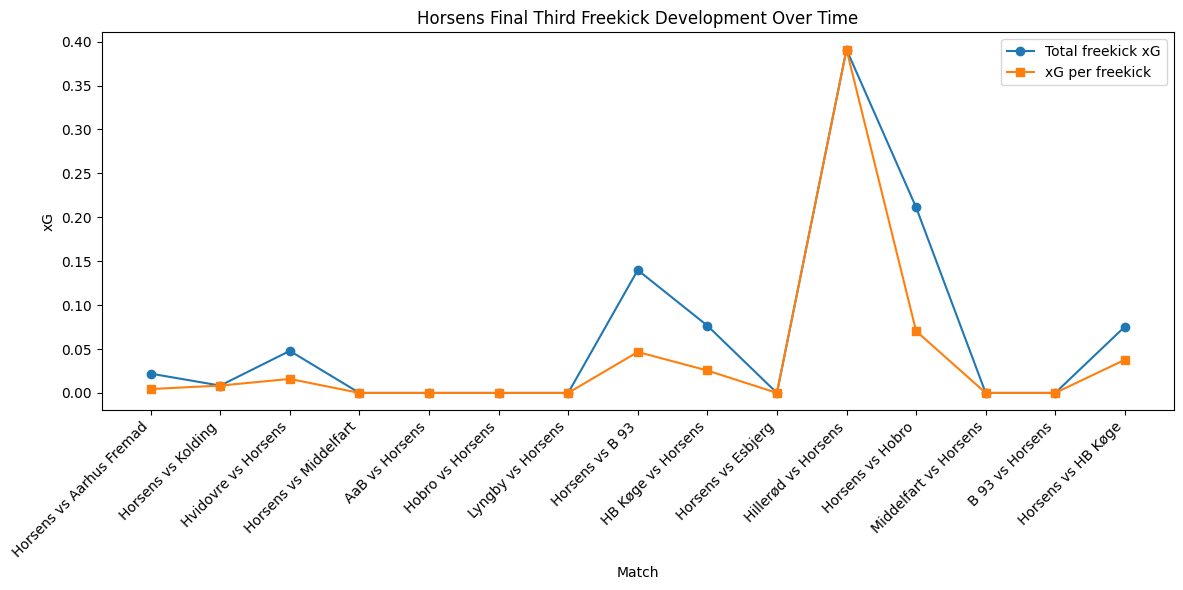


=== League table: Final Third Freekick (xG per piece, total xG, count) ===
    team_name  xG_per_piece  xG_total  freekick_taken
     Hvidovre         0.090     1.880              21
      HB Køge         0.056     1.393              25
       Lyngby         0.049     1.515              31
      Kolding         0.047     1.410              30
      Esbjerg         0.036     0.902              25
      Horsens         0.034     0.973              29
        Hobro         0.030     0.747              25
     Hillerød         0.029     0.947              33
          AaB         0.028     0.726              26
Aarhus Fremad         0.018     0.562              31
   Middelfart         0.006     0.150              26
         B 93         0.004     0.089              24

Average xG per long throw-in (Horsens): 0.006
Total xG from long throw-ins (Horsens): 0.412
Number of long throw-ins (Horsens): 65


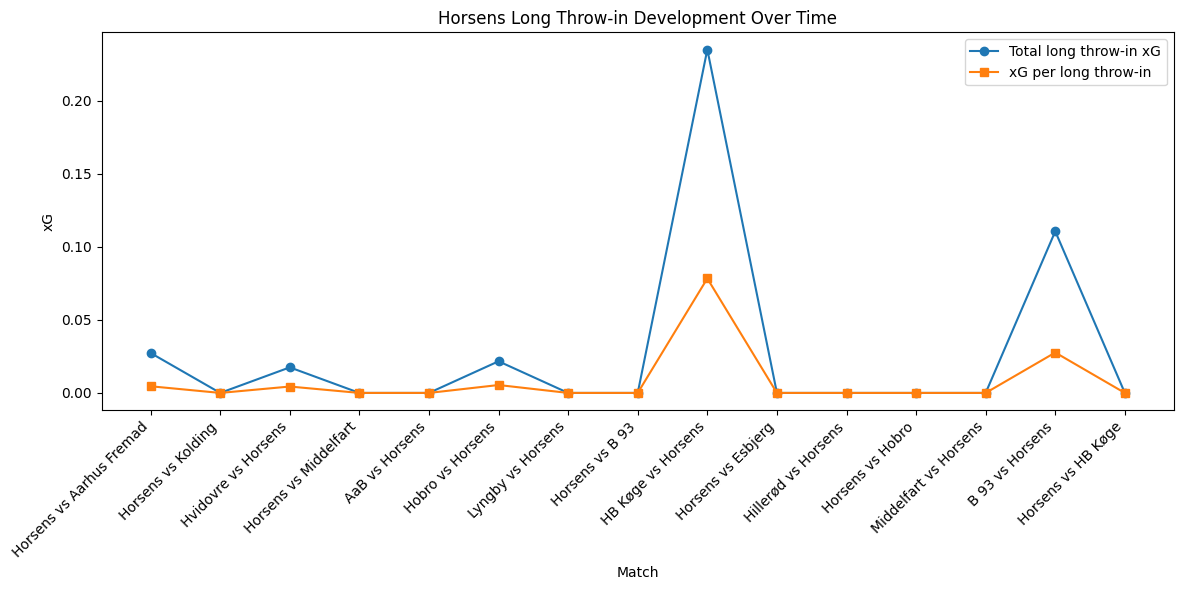


=== League table: Long Throw-ins (xG per throw-in, total xG, count) ===
    team_name  xG_per_throwin  xG_total  long_throwins_taken
      HB Køge           0.024     1.820                   75
         B 93           0.015     0.868                   58
        Hobro           0.014     0.852                   63
     Hillerød           0.013     0.470                   35
     Hvidovre           0.010     0.772                   74
      Esbjerg           0.009     0.657                   75
      Kolding           0.009     0.684                   75
       Lyngby           0.008     0.424                   56
Aarhus Fremad           0.006     0.338                   61
      Horsens           0.006     0.412                   65
   Middelfart           0.006     0.505                   86
          AaB           0.002     0.097                   54


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv(
    r'C:\Users\Seamus-admin\Documents\GitHub\AC-Horsens-First-Team\DNK_1_Division_2025_2026\set_piece_DNK_1_Division_2025_2026.csv'
)

# Function to process any set piece type
def process_set_piece(df, piece_type, extra_filter=None, title="Set Piece"):
    # --- Filter specific set piece type ---
    pieces = df[df['set_piece_type'] == piece_type].copy()
    if piece_type == "freekick":
        pieces = pieces[pieces['x'] > 66]
   
    # Apply extra filter if provided
    if extra_filter is not None:
        pieces = pieces.query(extra_filter)
    
    # Sort so IDs are sequential
    pieces = pieces.sort_values(['match_id', 'team_name', 'date', 'set_piece_index'])
    
    # Create running unique set piece ID (new ID whenever index == 1)
    pieces['set_piece_uid'] = (pieces['set_piece_index'] == 1).cumsum()
    
    # Corner type is only relevant for corners, but keep column for consistency
    pieces['corner_type'] = pieces.apply(
        lambda row: 'inswinger' if row.get('223.0', 0) == 1 
        else ('outswinger' if row.get('224.0', 0) == 1 else 'other'),
        axis=1
    )
    
    # Aggregate to set-piece level (xG only from 321.0)
    agg_pieces = (
        pieces.groupby(['set_piece_uid', 'match_id', 'team_name', 'date', 'label'])
        .agg(
            corner_type=('corner_type', lambda x: 'inswinger' if 'inswinger' in x.values 
                         else 'outswinger' if 'outswinger' in x.values else 'other'),
            xG=('321.0', 'sum')   # total xG from shots in this set piece
        )
        .reset_index()
    )
    
    # --- Horsens only ---
    horsens_pieces = agg_pieces[agg_pieces['team_name'] == 'Horsens']
    
    # Horsens stats
    xg_per_piece = horsens_pieces['xG'].mean()
    xg_total_pieces = horsens_pieces['xG'].sum()
    num_pieces_horsens = horsens_pieces['set_piece_uid'].nunique()
    
    print(f"\nAverage xG per {piece_type} (Horsens):", round(xg_per_piece, 3))
    print(f"Total xG from {piece_type} (Horsens):", round(xg_total_pieces, 3))
    print(f"Number of {piece_type}s (Horsens):", num_pieces_horsens)
    
    # Over time
    xg_over_time = horsens_pieces.groupby(['date', 'label'])['xG'].sum().reset_index()
    xg_per_piece_over_time = horsens_pieces.groupby(['date', 'label'])['xG'].mean().reset_index()
    
    # Plot Horsens development over time
    plt.figure(figsize=(12,6))
    plt.plot(xg_over_time['label'], xg_over_time['xG'], marker='o', label=f"Total {piece_type} xG")
    plt.plot(xg_per_piece_over_time['label'], xg_per_piece_over_time['xG'], marker='s', label=f"xG per {piece_type}")
    
    plt.title(f"Horsens {title} Development Over Time")
    plt.xlabel("Match")
    plt.ylabel("xG")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # --- League-wide rankings with counts ---
    xg_per_piece_team = agg_pieces.groupby('team_name')['xG'].mean().reset_index()
    xg_total_pieces_team = agg_pieces.groupby('team_name')['xG'].sum().reset_index()
    pieces_count_team = (
        agg_pieces.groupby('team_name')['set_piece_uid']
        .nunique()
        .reset_index()
        .rename(columns={'set_piece_uid': f'{piece_type}_taken'})
    )
    
    xg_table = (
        xg_per_piece_team
        .merge(xg_total_pieces_team, on='team_name', suffixes=('_per_piece', '_total'))
        .merge(pieces_count_team, on='team_name')
        .round(3)
        .sort_values('xG_per_piece', ascending=False)
    )
    
    print(f"\n=== League table: {title} (xG per piece, total xG, count) ===")
    print(xg_table.to_string(index=False))
    
    return agg_pieces


# --- Process corners ---
agg_corners = process_set_piece(df, "corner", title="Corner")

# --- Process freekicks ---
agg_freekicks = process_set_piece(
    df, 
    "freekick", 
    title="Final Third Freekick"
)


# --- Long throw-ins in final third ---
throwins = df[df['set_piece_type'] == 'throw_in'].copy()

# Make sure numeric
throwins['x'] = pd.to_numeric(throwins['x'], errors='coerce')
throwins['212.0'] = pd.to_numeric(throwins['212.0'], errors='coerce')

# Sort
throwins = throwins.sort_values(['match_id', 'team_name', 'date', 'set_piece_index'])

# Create running set piece UID
throwins['set_piece_uid'] = (throwins['set_piece_index'] == 1).cumsum()

# Identify long throw-ins in final third
long_throwins = throwins[(throwins['x'] > 66) & (throwins['212.0'] > 15)]
long_throwin_ids = long_throwins['set_piece_uid'].unique()

# Get all actions from those throw-in sequences
long_throwin_sequences = throwins[throwins['set_piece_uid'].isin(long_throwin_ids)].copy()

# Aggregate
agg_long_throwins = (
    long_throwin_sequences.groupby(['set_piece_uid', 'match_id', 'team_name', 'date', 'label'])
    .agg(xG=('321.0', 'sum'))
    .reset_index()
)

# Horsens stats
horsens_long_throwins = agg_long_throwins[agg_long_throwins['team_name'] == 'Horsens']
xg_per_throwin = horsens_long_throwins['xG'].mean()
xg_total_throwins = horsens_long_throwins['xG'].sum()
num_throwins_horsens = horsens_long_throwins['set_piece_uid'].nunique()

print("\nAverage xG per long throw-in (Horsens):", round(xg_per_throwin, 3))
print("Total xG from long throw-ins (Horsens):", round(xg_total_throwins, 3))
print("Number of long throw-ins (Horsens):", num_throwins_horsens)

# Over time plot
xg_over_time_throwin = horsens_long_throwins.groupby(['date', 'label'])['xG'].sum().reset_index()
xg_per_throwin_over_time = horsens_long_throwins.groupby(['date', 'label'])['xG'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(xg_over_time_throwin['label'], xg_over_time_throwin['xG'], marker='o', label="Total long throw-in xG")
plt.plot(xg_per_throwin_over_time['label'], xg_per_throwin_over_time['xG'], marker='s', label="xG per long throw-in")

plt.title("Horsens Long Throw-in Development Over Time")
plt.xlabel("Match")
plt.ylabel("xG")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- League-wide long throw-in table ---
xg_per_throwin_team = agg_long_throwins.groupby('team_name')['xG'].mean().reset_index()
xg_total_throwins_team = agg_long_throwins.groupby('team_name')['xG'].sum().reset_index()
throwins_count_team = (
    agg_long_throwins.groupby('team_name')['set_piece_uid']
    .nunique()
    .reset_index()
    .rename(columns={'set_piece_uid': 'long_throwins_taken'})
)

xg_table_throwins = (
    xg_per_throwin_team
    .merge(xg_total_throwins_team, on='team_name', suffixes=('_per_throwin', '_total'))
    .merge(throwins_count_team, on='team_name')
    .round(3)
    .sort_values('xG_per_throwin', ascending=False)
)

print("\n=== League table: Long Throw-ins (xG per throw-in, total xG, count) ===")
print(xg_table_throwins.to_string(index=False))
